In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE


In [ ]:
df = pd.read_csv("/content/googleplaystore.csv")


df.drop_duplicates(inplace=True)
df=df.drop(df[df["Category"]=="1.9"].index)
df.dropna(subset=["Rating"], inplace=True)


df["Reviews"] = df["Reviews"].astype(int)

def size_convert(size):
    if size == "Varies with device":
        return np.nan
    elif size.endswith("M"):
        return float(size.replace("M", ""))
    elif size.endswith("k"):
        return float(size.replace("k", "")) / 1000
    else:
        return np.nan

df["Size"] = df["Size"].apply(size_convert)
df["Size"].fillna(df["Size"].median(), inplace=True)

df["Installs"] = df["Installs"].str.replace(",", "").str.replace("+", "").astype(int)
df["Price"] = df["Price"].str.replace("$", "").astype(float)


/tmp/ipython-input-1060423663.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Size"].fillna(df["Size"].median(), inplace=True)


In [ ]:

df["Last Updated"] = pd.to_datetime(df["Last Updated"], errors='coerce')
df["update_month"] = df["Last Updated"].dt.month
df["month_sin"] = np.sin(2 * np.pi * df["update_month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["update_month"] / 12)

df[["Primary_genre", "Secondary_genre"]] = df["Genres"].str.split(";", expand=True).fillna("None")

top_categories = df["Category"].value_counts().nlargest(10).index
df["Category_grouped"] = df["Category"].apply(lambda x: x if x in top_categories else "other")

top_genres = df["Primary_genre"].value_counts().nlargest(10).index
df["Primary_genre_grouped"] = df["Primary_genre"].apply(lambda x: x if x in top_genres else "other")

rating_map = {
    "Everyone": "0+",
    "Teen": "13+",
    "Everyone 10+": "10+",
    "Mature 17+": "17+",
    "Adults only 18+": "18+",
    "Unrated": "Unrated"
}
df["Content Rating"] = df["Content Rating"].map(rating_map)
rating_group_map = {
    "0+": "Everyone",
    "10+": "Upto 18",
    "13+": "Upto 18",
    "17+": "Upto 18",
    "18+": "Above 18",
    "Unrated": "Unrated"
}
df["Content_Rating_Grouped"] = df["Content Rating"].map(rating_group_map)

df["is_paid"] = df["Type"].apply(lambda x: 1 if x == "Paid" else 0)


In [ ]:
df.drop(columns=[
    "App", "Category", "Primary_genre", "Secondary_genre", "Genres",
    "Last Updated", "Content Rating", "update_month",  "Type", "Price","Current Ver","Android Ver"
], inplace=True)

X = df.drop(columns=["Rating"])
y = df["Rating"]


In [ ]:

cat_cols = ["Category_grouped", "Primary_genre_grouped", "Content_Rating_Grouped"]
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)


x_train, x_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.25, random_state=42)



pt = PowerTransformer()
x_train[["Reviews", "Size", "Installs"]] = pt.fit_transform(x_train[["Reviews", "Size", "Installs"]])
x_test[["Reviews", "Size", "Installs"]] = pt.transform(x_test[["Reviews", "Size", "Installs"]])


In [ ]:
x_train.head()

,Reviews,Size,Installs,month_sin,month_cos,is_paid,Category_grouped_FAMILY,Category_grouped_FINANCE,Category_grouped_GAME,Category_grouped_LIFESTYLE,...,Primary_genre_grouped_Finance,Primary_genre_grouped_Lifestyle,Primary_genre_grouped_Personalization,Primary_genre_grouped_Photography,Primary_genre_grouped_Productivity,Primary_genre_grouped_Tools,Primary_genre_grouped_other,Content_Rating_Grouped_Everyone,Content_Rating_Grouped_Unrated,Content_Rating_Grouped_Upto 18
1807,0.860900,-0.000752,0.844072,-5.000000e-01,-8.660254e-01,0,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
6017,-0.711052,-1.075834,-0.803774,1.224647e-16,-1.000000e+00,0,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
3559,0.475308,-0.000752,0.386736,-5.000000e-01,-8.660254e-01,0,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
4540,-1.393115,-1.483741,-0.803774,-1.000000e+00,-1.836970e-16,0,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
861,0.851506,-0.000752,0.844072,1.224647e-16,-1.000000e+00,0,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [ ]:
y_class_train = pd.cut(y_train, bins=[0, 3.9, 4.3, 5.0], labels=["Low", "Medium", "High"])
y_class_test = pd.cut(y_test, bins=[0, 3.9, 4.3, 5.0], labels=["Low", "Medium", "High"])

ordinal_map = {"Low": 0, "Medium": 1, "High": 2}
y_resampled_ord = y_class_train.map(ordinal_map)
y_class_test_ord = y_class_test.map(ordinal_map)


In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(x_train, y_resampled_ord)


In [ ]:
rf_final = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    bootstrap=True,
    class_weight='balanced',
    random_state=42
)


rf_final.fit(X_resampled, y_resampled)
y_pred_final = rf_final.predict(x_test)


✅ Final Accuracy: 0.5330634278002699
📊 Final Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.46      0.42       453
           1       0.51      0.48      0.50       776
           2       0.63      0.61      0.62       994

    accuracy                           0.53      2223
   macro avg       0.51      0.52      0.51      2223
weighted avg       0.54      0.53      0.54      2223



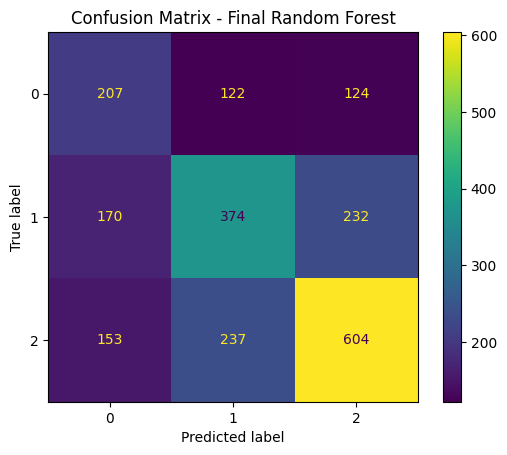

In [ ]:
print("✅ Final Accuracy:", accuracy_score(y_class_test_ord, y_pred_final))
print("📊 Final Classification Report:\n", classification_report(y_class_test_ord, y_pred_final))

ConfusionMatrixDisplay.from_estimator(rf_final, x_test, y_class_test_ord)
plt.title("Confusion Matrix - Final Random Forest")
plt.show()


In [ ]:
!pip install category_encoders

from category_encoders import TargetEncoder

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

te = TargetEncoder()
x_train_te = x_train.copy()
x_test_te = x_test.copy()

for col in ["Category_grouped", "Primary_genre_grouped", "Content_Rating_Grouped"]:
    te.fit(x_train_te[col], y_resampled_ord)
    x_train_te[col] = te.transform(x_train_te[col])
    x_test_te[col] = te.transform(x_test_te[col])


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.6 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer()
cols_to_scale = ["Reviews", "Size", "Installs", ]

x_train_te[cols_to_scale] = pt.fit_transform(x_train_te[cols_to_scale])
x_test_te[cols_to_scale] = pt.transform(x_test_te[cols_to_scale])
y_class_train = pd.cut(y_train, bins=[0, 4, 5.0], labels=["Low", "High"])
y_class_test = pd.cut(y_test, bins=[0, 4.0, 5.0], labels=["Low", "High"])


ordinal_map = {"Low": 0, "High": 1}
y_resampled_ord = y_class_train.map(ordinal_map)
y_class_test_ord = y_class_test.map(ordinal_map)

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(x_train_te, y_resampled_ord)



In [ ]:
X_resampled.head()

,Reviews,Size,Installs,month_sin,month_cos,Category_grouped,Primary_genre_grouped,Content_Rating_Grouped,is_paid
0,0.860900,-0.000752,0.844072,-5.000000e-01,-8.660254e-01,1.342308,1.222746,1.186454,0
1,-0.711052,-1.075834,-0.803774,1.224647e-16,-1.000000e+00,1.266667,1.266667,1.208372,0
2,0.475308,-0.000752,0.386736,-5.000000e-01,-8.660254e-01,1.266667,1.266667,1.208372,0
3,-1.393115,-1.483741,-0.803774,-1.000000e+00,-1.836970e-16,1.175665,1.378973,1.208372,0
4,0.851506,-0.000752,0.844072,1.224647e-16,-1.000000e+00,1.208968,0.992665,1.208372,0


In [ ]:
X_resampled["review_density"] = X_resampled["Reviews"] / (X_resampled["Size"] + 1e-5)
x_test_te["review_density"] = x_test_te["Reviews"] / (x_test_te["Size"] + 1e-5)

X_resampled["install_to_review_ratio"] = X_resampled["Installs"] / (X_resampled["Reviews"] + 1e-5)
x_test_te["install_to_review_ratio"] = x_test_te["Installs"] / (x_test_te["Reviews"] + 1e-5)

X_resampled["update_angle"] = np.arctan2(X_resampled["month_sin"], X_resampled["month_cos"])
x_test_te["update_angle"] = np.arctan2(x_test_te["month_sin"], x_test_te["month_cos"])

In [ ]:
X_resampled.head()

,Reviews,Size,Installs,month_sin,month_cos,Category_grouped,Primary_genre_grouped,Content_Rating_Grouped,is_paid,review_density,install_to_review_ratio,update_angle
0,0.860900,-0.000752,0.844072,-5.000000e-01,-8.660254e-01,1.342308,1.222746,1.186454,0,-1159.574978,0.980442,-2.617994
1,-0.711052,-1.075834,-0.803774,1.224647e-16,-1.000000e+00,1.266667,1.266667,1.208372,0,0.660937,1.130417,3.141593
2,0.475308,-0.000752,0.386736,-5.000000e-01,-8.660254e-01,1.266667,1.266667,1.208372,0,-640.207916,0.813638,-2.617994
3,-1.393115,-1.483741,-0.803774,-1.000000e+00,-1.836970e-16,1.175665,1.378973,1.208372,0,0.938927,0.576965,-1.570796
4,0.851506,-0.000752,0.844072,1.224647e-16,-1.000000e+00,1.208968,0.992665,1.208372,0,-1146.922483,0.991258,3.141593


In [ ]:
rf_final = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    bootstrap=True,
    class_weight='balanced',
    random_state=42
)

rf_final.fit(X_resampled, y_resampled)
y_pred_final = rf_final.predict(x_test_te)



✅ Final Accuracy: 0.7242465137201979
📊 Final Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.46      0.47       583
           1       0.81      0.82      0.81      1640

    accuracy                           0.72      2223
   macro avg       0.64      0.64      0.64      2223
weighted avg       0.72      0.72      0.72      2223



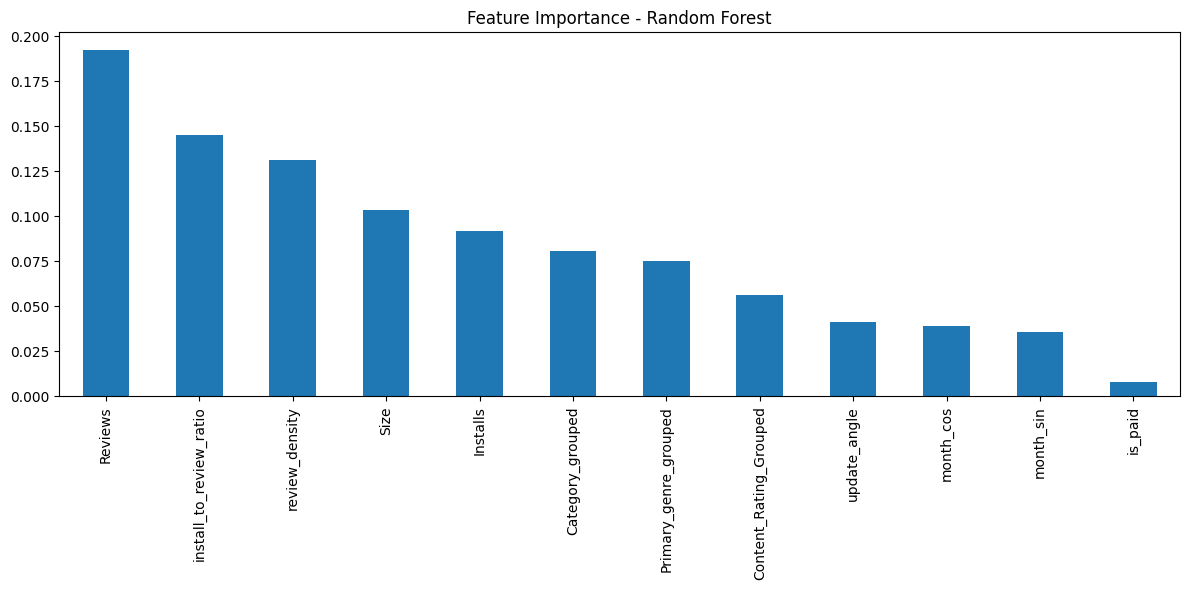

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("✅ Final Accuracy:", accuracy_score(y_class_test_ord, y_pred_final))
print("📊 Final Classification Report:\n", classification_report(y_class_test_ord, y_pred_final))




feature_importances = pd.Series(rf_final.feature_importances_, index=X_resampled.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title("Feature Importance - Random Forest")
plt.tight_layout()
plt.show()


In [ ]:
top_features = feature_importances.sort_values(ascending=False).head(10).index.tolist()
X_selected = X_resampled[top_features]
x_test_selected = x_test_te[top_features]

rf_final.fit(X_selected, y_resampled)
y_pred_selected = rf_final.predict(x_test_selected)
print("Ordinal Accuracy:", accuracy_score(y_class_test_ord, y_pred_selected))

Ordinal Accuracy: 0.7251461988304093


In [ ]:
X_selected.head()

,Reviews,install_to_review_ratio,review_density,Size,Installs,Category_grouped,Primary_genre_grouped,Content_Rating_Grouped,update_angle,month_cos
0,0.860900,0.980442,-1159.574978,-0.000752,0.844072,1.342308,1.222746,1.186454,-2.617994,-8.660254e-01
1,-0.711052,1.130417,0.660937,-1.075834,-0.803774,1.266667,1.266667,1.208372,3.141593,-1.000000e+00
2,0.475308,0.813638,-640.207916,-0.000752,0.386736,1.266667,1.266667,1.208372,-2.617994,-8.660254e-01
3,-1.393115,0.576965,0.938927,-1.483741,-0.803774,1.175665,1.378973,1.208372,-1.570796,-1.836970e-16
4,0.851506,0.991258,-1146.922483,-0.000752,0.844072,1.208968,0.992665,1.208372,3.141593,-1.000000e+00


In [ ]:
!pip install mord
from mord import LogisticAT


y_resampled = y_resampled.astype(int)

ord_model = LogisticAT()
ord_model.fit(X_resampled, y_resampled)
y_pred_ord = ord_model.predict(x_test_te)

print("Ordinal Accuracy:", accuracy_score(y_class_test_ord, y_pred_ord))


Ordinal Accuracy: 0.6734143049932524


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(x_test_te)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("🔢 PCA components retained:", pca.n_components_)


🔢 PCA components retained: 9


In [ ]:
rf_final.fit(X_pca, y_resampled)
y_pred_pca = rf_final.predict(X_test_pca)

print("✅ Final Accuracy:", accuracy_score(y_class_test_ord, y_pred_pca))
print("📊 Final Classification Report:\n", classification_report(y_class_test_ord, y_pred_pca))

✅ Final Accuracy: 0.6846603688708952
📊 Final Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.48      0.45       583
           1       0.80      0.76      0.78      1640

    accuracy                           0.68      2223
   macro avg       0.61      0.62      0.61      2223
weighted avg       0.70      0.68      0.69      2223



In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(X_resampled, y_resampled)
X_test_lda = lda.transform(x_test_te)

rf_final.fit(X_lda, y_resampled)
y_pred_lda = rf_final.predict(X_test_lda)

print("✅ Final Accuracy:", accuracy_score(y_class_test_ord, y_pred_lda))
print("📊 Final Classification Report:\n", classification_report(y_class_test_ord, y_pred_lda))

✅ Final Accuracy: 0.6248313090418354
📊 Final Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.61      0.46       583
           1       0.82      0.63      0.71      1640

    accuracy                           0.62      2223
   macro avg       0.59      0.62      0.59      2223
weighted avg       0.70      0.62      0.65      2223



In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_selected, y_resampled)
y_pred_xgb = xgb_model.predict(x_test_selected)

print("selected Accuracy:", accuracy_score(y_class_test_ord, y_pred_xgb))
print("selected Classification Report:\n", classification_report(y_class_test_ord, y_pred_xgb))

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

xgb_model.fit(X_resampled, y_resampled)
y_pred_final = xgb_model.predict(x_test_te)

print("✅ all Accuracy:", accuracy_score(y_class_test_ord, y_pred_final))
print("📊 all Classification Report:\n", classification_report(y_class_test_ord, y_pred_final))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:21:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


selected Accuracy: 0.7215474583895637
selected Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.44      0.45       583
           1       0.80      0.82      0.81      1640

    accuracy                           0.72      2223
   macro avg       0.64      0.63      0.63      2223
weighted avg       0.72      0.72      0.72      2223



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:21:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ all Accuracy: 0.7242465137201979
📊 all Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.45      0.46       583
           1       0.81      0.82      0.81      1640

    accuracy                           0.72      2223
   macro avg       0.64      0.63      0.64      2223
weighted avg       0.72      0.72      0.72      2223



In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_selected, y_resampled)
y_pred_xgb = cat_model.predict(x_test_selected)



print("selected Accuracy:", accuracy_score(y_class_test_ord, y_pred_xgb))
print("selected Classification Report:\n", classification_report(y_class_test_ord, y_pred_xgb))

xgb_model = CatBoostClassifier(verbose=0, random_state=42)

xgb_model.fit(X_resampled, y_resampled)
y_pred_final = xgb_model.predict(x_test_te)

print("✅ all Accuracy:", accuracy_score(y_class_test_ord, y_pred_final))
print("📊 all Classification Report:\n", classification_report(y_class_test_ord, y_pred_final))


selected Accuracy: 0.7273954116059379
selected Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.48      0.48       583
           1       0.82      0.81      0.82      1640

    accuracy                           0.73      2223
   macro avg       0.65      0.65      0.65      2223
weighted avg       0.73      0.73      0.73      2223

✅ all Accuracy: 0.7192982456140351
📊 all Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.47      0.47       583
           1       0.81      0.81      0.81      1640

    accuracy                           0.72      2223
   macro avg       0.64      0.64      0.64      2223
weighted avg       0.72      0.72      0.72      2223



In [ ]:
from sklearn.linear_model import LogisticRegression

cat_model = LogisticRegression(max_iter=1000)
cat_model.fit(X_selected, y_resampled)
y_pred_xgb = cat_model.predict(x_test_selected)

print("selected Accuracy:", accuracy_score(y_class_test_ord, y_pred_xgb))
print("selected Classification Report:\n", classification_report(y_class_test_ord, y_pred_xgb))

xgb_model =  LogisticRegression(max_iter=1000)
xgb_model.fit(X_resampled, y_resampled)
y_pred_final = xgb_model.predict(x_test_te)

print("✅ all Accuracy:", accuracy_score(y_class_test_ord, y_pred_final))
print("📊 all Classification Report:\n", classification_report(y_class_test_ord, y_pred_final))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


selected Accuracy: 0.6716149347728295
selected Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.68      0.52       583
           1       0.85      0.67      0.75      1640

    accuracy                           0.67      2223
   macro avg       0.64      0.67      0.64      2223
weighted avg       0.74      0.67      0.69      2223

✅ all Accuracy: 0.675663517768781
📊 all Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.68      0.52       583
           1       0.85      0.68      0.75      1640

    accuracy                           0.68      2223
   macro avg       0.64      0.68      0.64      2223
weighted avg       0.74      0.68      0.69      2223



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'class_weight': [None]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid_rf,
                       cv=5,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       verbose=2)

grid_rf.fit(X_resampled, y_resampled)
rf_best = grid_rf.best_estimator_
y_pred_rf = rf_best.predict(x_test_te)

print("🔍 Random Forest Best Parameters:", grid_rf.best_params_)
print("✅ Accuracy:", accuracy_score(y_class_test_ord, y_pred_rf))
print(classification_report(y_class_test_ord, y_pred_rf))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
🔍 Random Forest Best Parameters: {'bootstrap': True, 'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
✅ Accuracy: 0.7201979307242465
              precision    recall  f1-score   support

           0       0.47      0.46      0.46       583
           1       0.81      0.81      0.81      1640

    accuracy                           0.72      2223
   macro avg       0.64      0.64      0.64      2223
weighted avg       0.72      0.72      0.72      2223



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}

grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=42),
                       param_grid_gb,
                       cv=5,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       verbose=3)


grid_gb.fit(X_resampled, y_resampled)
gb_best = grid_gb.best_estimator_
y_pred_gb = gb_best.predict(x_test_te)

print("🔍 Gradient Boosting Best Parameters:", grid_gb.best_params_)
print("✅ Accuracy:", accuracy_score(y_class_test_ord, y_pred_gb))
print("📊 Classification Report:\n", classification_report(y_class_test_ord, y_pred_gb))


Fitting 5 folds for each of 972 candidates, totalling 4860 fits
🔍 Gradient Boosting Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.8}
✅ Accuracy: 0.7260458839406208
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.45      0.46       583
           1       0.81      0.83      0.82      1640

    accuracy                           0.73      2223
   macro avg       0.64      0.64      0.64      2223
weighted avg       0.72      0.73      0.72      2223



In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

param_grid_xgb_optimized = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 6],
    'min_child_weight': [1, 3],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.1],

    'reg_lambda': [1]
}

grid_xgb = GridSearchCV(
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    param_grid=param_grid_xgb_optimized,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

grid_xgb.fit(X_resampled, y_resampled)

xgb_best = grid_xgb.best_estimator_
y_pred_xgb = xgb_best.predict(x_test_te)

print("🔍 XGBoost Best Parameters:", grid_xgb.best_params_)
print("✅ Accuracy:", accuracy_score(y_class_test_ord, y_pred_xgb))
print("📊 Classification Report:\n", classification_report(y_class_test_ord, y_pred_xgb))


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

param_grids_svm_optimized = {
    "poly": {
        'C': [1, 10],
        'kernel': ['poly'],
        'degree': [2],
        'gamma': ['scale'],
        'class_weight': ['balanced']
    },
    "rbf": {
        'C': [1, 10],
        'kernel': ['rbf'],
        'gamma': ['scale'],
        'class_weight': ['balanced']
    },
    "linear": {
        'C': [1, 10],
        'kernel': ['linear'],
        'class_weight': ['balanced']
    }
}


for kernel_name, param_grid in param_grids_svm_optimized.items():
    print(f"\n🔍 Running GridSearchCV for SVM with {kernel_name} kernel...")
    try:
        grid_svm = GridSearchCV(
            SVC(),
            param_grid,
            cv=5,
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=2
        )
        grid_svm.fit(X_resampled, y_resampled)
        svm_best = grid_svm.best_estimator_
        y_pred_svm = svm_best.predict(x_test_te)

        print(f"✅ SVM ({kernel_name}) Best Parameters:", grid_svm.best_params_)
        print("✅ Accuracy:", accuracy_score(y_class_test_ord, y_pred_svm))
        print("📊 Classification Report:\n", classification_report(y_class_test_ord, y_pred_svm))
    except Exception as e:
        print(f"❌ Error with SVM ({kernel_name}) kernel: {e}")


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score


grids_lr_optimized = {
    "L1": {
        'penalty': ['l1'],
        'C': [0.5, 1.0, 2.0],
        'solver': ['liblinear'],
        'class_weight': [None],
        'max_iter': [1000]
    },
    "L2": {
        'penalty': ['l2'],
        'C': [0.5, 1.0, 2.0],
        'solver': ['liblinear'],
        'class_weight': [None],
        'max_iter': [1000]
    },
    "ElasticNet": {
        'penalty': ['elasticnet'],
        'C': [0.5, 1.0, 2.0],
        'solver': ['saga'],
        'class_weight': [None],
        'max_iter': [1000],
        'l1_ratio': [0.5, 0.7]
    }
}

for name, param_grid in grids_lr_optimized.items():
    print(f"\n🔍 Running GridSearchCV for Logistic Regression ({name})...")
    try:
        grid_lr = GridSearchCV(
            LogisticRegression(),
            param_grid,
            cv=5,
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=2
        )
        grid_lr.fit(X_resampled, y_resampled)
        lr_best = grid_lr.best_estimator_
        y_pred_lr = lr_best.predict(x_test_te)

        print(f"✅ Logistic Regression ({name}) Best Parameters:", grid_lr.best_params_)
        print("✅ Accuracy:", accuracy_score(y_class_test_ord, y_pred_lr))
        print("📊 Classification Report:\n", classification_report(y_class_test_ord, y_pred_lr))
    except Exception as e:
        print(f"❌ Error with Logistic Regression ({name}): {e}")


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
x_test_scaled = scaler.transform(x_test_te)

param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

grid_knn.fit(X_resampled_scaled, y_resampled)

knn_best = grid_knn.best_estimator_
y_pred_knn = knn_best.predict(x_test_scaled)

print("🔍 KNN Best Parameters:", grid_knn.best_params_)
print("✅ Accuracy:", accuracy_score(y_class_test_ord, y_pred_knn))
print("📊 Classification Report:\n", classification_report(y_class_test_ord, y_pred_knn))

ConfusionMatrixDisplay.from_estimator(knn_best, x_test_scaled, y_class_test_ord)
plt.title("Confusion Matrix - KNN")
plt.show()


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score


param_grid_dt_optimized = {
    'criterion': ['gini'],
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

# Grid search setup
grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt_optimized,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

# Fit model
grid_dt.fit(X_resampled, y_resampled)

# Best model and predictions
dt_best = grid_dt.best_estimator_
y_pred_dt = dt_best.predict(x_test_te)

# Evaluation
print("🔍 Decision Tree Best Parameters:", grid_dt.best_params_)
print("✅ Accuracy:", accuracy_score(y_class_test_ord, y_pred_dt))
print("📊 Classification Report:\n", classification_report(y_class_test_ord, y_pred_dt))


In [ ]:
# the model we have trained results are Fitting 5 folds for each of 12 candidates, totalling 60 fits
# 🔍 Decision Tree Best Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
# ✅ Accuracy: 0.6851102114260009
# 📊 Classification Report:
#                precision    recall  f1-score   support

#            0       0.41      0.48      0.44       583
#            1       0.80      0.76      0.78      1640

#     accuracy                           0.69      2223
#    macro avg       0.61      0.62      0.61      2223
# weighted avg       0.70      0.69      0.69      2223
# Fitting 5 folds for each of 18 candidates, totalling 90 fits



# 🔍 KNN Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
# ✅ Accuracy: 0.6747638326585695
# 📊 Classification Report:
#                precision    recall  f1-score   support

#            0       0.40      0.45      0.42       583
#            1       0.80      0.75      0.77      1640

#     accuracy                           0.67      2223
#    macro avg       0.60      0.60      0.60      2223
# weighted avg       0.69      0.67      0.68      2223
# 🔍 Running GridSearchCV for Logistic Regression (L1)...
# Fitting 5 folds for each of 6 candidates, totalling 30 fits
# /usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning:
# 15 fits failed out of a total of 30.
# The score on these train-test partitions for these parameters will be set to nan.
# If these failures are not expected, you can try to debug them by setting error_score='raise'.

# Below are more details about the failures:
# --------------------------------------------------------------------------------
# 15 fits failed with the following error:
# Traceback (most recent call last):
#   File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
#     estimator.fit(X_train, y_train, **fit_params)
#   File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
#     estimator._validate_params()
#   File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
#     validate_parameter_constraints(
#   File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py", line 98, in validate_parameter_constraints
#     raise InvalidParameterError(
# sklearn.utils._param_validation.InvalidParameterError: The 'max_iter' parameter of LogisticRegression must be an int in the range [0, inf). Got None instead.

#   warnings.warn(some_fits_failed_message, FitFailedWarning)
# /usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.69086284        nan 0.69181632        nan 0.69119542        nan]
#   warnings.warn(


# ✅ Logistic Regression (L1) Best Parameters: {'C': 1.0, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
# ✅ Accuracy: 0.6734143049932524
# 📊 Classification Report:
#                precision    recall  f1-score   support

#            0       0.42      0.67      0.52       583
#            1       0.85      0.67      0.75      1640

#     accuracy                           0.67      2223
#    macro avg       0.64      0.67      0.64      2223
# weighted avg       0.74      0.67      0.69      2223



# 🔍 Running GridSearchCV for Logistic Regression (L2)...
# Fitting 5 folds for each of 6 candidates, totalling 30 fits
# /usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning:
# 15 fits failed out of a total of 30.
# The score on these train-test partitions for these parameters will be set to nan.
# If these failures are not expected, you can try to debug them by setting error_score='raise'.

# Below are more details about the failures:
# --------------------------------------------------------------------------------
# 15 fits failed with the following error:
# Traceback (most recent call last):
#   File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
#     estimator.fit(X_train, y_train, **fit_params)
#   File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
#     estimator._validate_params()
#   File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
#     validate_parameter_constraints(
#   File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py", line 98, in validate_parameter_constraints
#     raise InvalidParameterError(
# sklearn.utils._param_validation.InvalidParameterError: The 'max_iter' parameter of LogisticRegression must be an int in the range [0, inf). Got None instead.

#   warnings.warn(some_fits_failed_message, FitFailedWarning)
# /usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.69159932        nan 0.68940502        nan 0.6926727         nan]
#   warnings.warn(


# ✅ Logistic Regression (L2) Best Parameters: {'C': 2.0, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
# ✅ Accuracy: 0.672514619883041
# 📊 Classification Report:
#                precision    recall  f1-score   support

#            0       0.42      0.67      0.52       583
#            1       0.85      0.67      0.75      1640

#     accuracy                           0.67      2223
#    macro avg       0.64      0.67      0.64      2223
# weighted avg       0.74      0.67      0.69      2223


# 🔍 Running GridSearchCV for Logistic Regression (ElasticNet)...
# Fitting 5 folds for each of 12 candidates, totalling 60 fits
# /usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning:
# 30 fits failed out of a total of 60.
# The score on these train-test partitions for these parameters will be set to nan.
# If these failures are not expected, you can try to debug them by setting error_score='raise'.

# Below are more details about the failures:
# --------------------------------------------------------------------------------
# 30 fits failed with the following error:
# Traceback (most recent call last):
#   File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
#     estimator.fit(X_train, y_train, **fit_params)
#   File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
#     estimator._validate_params()
#   File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
#     validate_parameter_constraints(
#   File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py", line 98, in validate_parameter_constraints
#     raise InvalidParameterError(
# sklearn.utils._param_validation.InvalidParameterError: The 'max_iter' parameter of LogisticRegression must be an int in the range [0, inf). Got None instead.

#   warnings.warn(some_fits_failed_message, FitFailedWarning)
# /usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.61613797        nan 0.61625022        nan 0.61623623        nan
#  0.61613762        nan 0.61633436        nan 0.61633436        nan]
#   warnings.warn(



# ✅ Logistic Regression (ElasticNet) Best Parameters: {'C': 2.0, 'class_weight': None, 'l1_ratio': 0.5, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'}
# ✅ Accuracy: 0.562753036437247
# 📊 Classification Report:
#                precision    recall  f1-score   support

#            0       0.34      0.70      0.46       583
#            1       0.83      0.51      0.63      1640

#     accuracy                           0.56      2223
#    macro avg       0.58      0.61      0.55      2223
# weighted avg       0.70      0.56      0.59      2223

# /usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
#   warnings.warn(
# Fitting 5 folds for each of 256 candidates, totalling 1280 fits
# /usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:02:12] WARNING: /workspace/src/learner.cc:738:
# Parameters: { "use_label_encoder" } are not used.

#   bst.update(dtrain, iteration=i, fobj=obj)


# 🔍 XGBoost Best Parameters: {}
# ✅ Accuracy: 0.7318938371569951'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.8
# 📊 Classification Report:
#                precision    recall  f1-score   support

#            0       0.49      0.48      0.48       583
#            1       0.82      0.82      0.82      1640

#     accuracy                           0.73      2223
#    macro avg       0.65      0.65      0.65      2223
# weighted avg       0.73      0.73      0.73      2223
# Fitting 5 folds for each of 32 candidates, totalling 160 fits


# 🔍 Gradient Boosting Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}
# ✅ Accuracy: 0.7201979307242465
# 📊 Classification Report:
#                precision    recall  f1-score   support

#            0       0.47      0.48      0.47       583
#            1       0.81      0.81      0.81      1640

#     accuracy                           0.72      2223
#    macro avg       0.64      0.64      0.64      2223
# weighted avg       0.72      0.72      0.72      2223


# Fitting 5 folds for each of 24 candidates, totalling 120 fits
# 🔍 Random Forest Best Parameters: {'bootstrap': True, 'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
# ✅ Accuracy: 0.7201979307242465
#               precision    recall  f1-score   support

#            0       0.47      0.46      0.46       583
#            1       0.81      0.81      0.81      1640

#     accuracy                           0.72      2223
#    macro avg       0.64      0.64      0.64      2223
# weighted avg       0.72      0.72      0.72      2223

# Fitting 5 folds for each of 972 candidates, totalling 4860 fits
# 🔍 Gradient Boosting Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.8}
# ✅ Accuracy: 0.7260458839406208
# 📊 Classification Report:
#                precision    recall  f1-score   support

#            0       0.48      0.45      0.46       583
#            1       0.81      0.83      0.82      1640

#     accuracy                           0.73      2223
#    macro avg       0.64      0.64      0.64      2223
# weighted avg       0.72      0.73      0.72      2223


# catboost(default)
# ✅ all Accuracy: 0.7192982456140351
# 📊 all Classification Report:
#                precision    recall  f1-score   support

#            0       0.47      0.47      0.47       583
#            1       0.81      0.81      0.81      1640

#     accuracy                           0.72      2223
#    macro avg       0.64      0.64      0.64      2223
# weighted avg       0.72      0.72      0.72      2223

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.9 MB/s eta 0:00:00


In [ ]:

import optuna
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

def objective_xgb(trial):
    model = XGBClassifier(
        n_estimators=trial.suggest_int('n_estimators', 100, 500),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
        max_depth=trial.suggest_int('max_depth', 3, 10),
        min_child_weight=trial.suggest_int('min_child_weight', 1, 10),
        subsample=trial.suggest_float('subsample', 0.6, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.6, 1.0),
        gamma=trial.suggest_float('gamma', 0, 0.5),
        reg_alpha=trial.suggest_float('reg_alpha', 0, 1),
        reg_lambda=trial.suggest_float('reg_lambda', 1, 3),
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )
    score = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='f1_weighted').mean()
    return score

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=50)
print("🔍 Best XGBoost Parameters:", study_xgb.best_trial.params)
print("🏆 Best F1 Score:", study_xgb.best_value)
best_trial = study_xgb.best_trial
print("Trial Number:", best_trial.number)
print("Best Parameters:", best_trial.params)
print("Best Score:", best_trial.value)


[I 2025-09-12 06:47:14,508] A new study created in memory with name: no-name-5f066e93-1aa0-4282-9d84-ed235f0b774a
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:47:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:47:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:47:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:47:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration

🔍 Best XGBoost Parameters: {'n_estimators': 182, 'learning_rate': 0.14073284907582245, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.7500735332168599, 'colsample_bytree': 0.7426550167477263, 'gamma': 0.30547973226477154, 'reg_alpha': 0.026088323076937314, 'reg_lambda': 2.2728894877035795}
🏆 Best F1 Score: 0.793251880270727
Trial Number: 23
Best Parameters: {'n_estimators': 182, 'learning_rate': 0.14073284907582245, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.7500735332168599, 'colsample_bytree': 0.7426550167477263, 'gamma': 0.30547973226477154, 'reg_alpha': 0.026088323076937314, 'reg_lambda': 2.2728894877035795}
Best Score: 0.793251880270727


In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

def objective_cat(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int('iterations', 100, 1000),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
        depth=trial.suggest_int('depth', 4, 10),
        l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 1, 10),
        border_count=trial.suggest_int('border_count', 32, 255),
        bagging_temperature=trial.suggest_float('bagging_temperature', 0, 1),
        random_strength=trial.suggest_float('random_strength', 0, 1),
        grow_policy=trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        verbose=0,
        random_state=42
    )
    score = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='f1_weighted').mean()
    return score

study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=50)
print("🔍 Best CatBoost Parameters:", study_cat.best_trial.params)
print("🏆 Best F1 Score:", study_cat.best_value)
best_trial = study_cat.best_trial
print("Trial Number:", best_trial.number)
print("Best Parameters:", best_trial.params)
print("Best Score:", best_trial.value)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


[I 2025-09-12 03:31:05,425] A new study created in memory with name: no-name-5adf0a49-71ab-4b55-8d36-e4a2cd8c9593
[I 2025-09-12 03:31:26,253] Trial 0 finished with value: 0.7772219791297807 and parameters: {'iterations': 454, 'learning_rate': 0.17733412576699237, 'depth': 5, 'l2_leaf_reg': 7.671483623535567, 'border_count': 142, 'bagging_temperature': 0.9795341273321394, 'random_strength': 0.07111565666612507, 'grow_policy': 'Lossguide'}. Best is trial 0 with value: 0.7772219791297807.
[I 2025-09-12 03:32:36,454] Trial 1 finished with value: 0.7802023173942054 and parameters: {'iterations': 731, 'learning_rate': 0.25591403557510806, 'depth': 7, 'l2_leaf_reg': 9.321578347633702, 'border_count': 197, 'bagging_temperature': 0.8458413542019901, 'random_strength': 0.8532375182235052, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.7802023173942054.
[I 2025-09-12 03:33:34,943] Trial 2 finished with value: 0.7892274663071881 and parameters: {'iterations': 732, 'learning_rate': 0.16

🔍 Best CatBoost Parameters: {'iterations': 851, 'learning_rate': 0.14090806071066586, 'depth': 9, 'l2_leaf_reg': 1.6276602969353386, 'border_count': 203, 'bagging_temperature': 0.20726177267535123, 'random_strength': 0.6973589737716657, 'grow_policy': 'SymmetricTree'}
🏆 Best F1 Score: 0.7982818312467587
Trial Number: 25
Best Parameters: {'iterations': 851, 'learning_rate': 0.14090806071066586, 'depth': 9, 'l2_leaf_reg': 1.6276602969353386, 'border_count': 203, 'bagging_temperature': 0.20726177267535123, 'random_strength': 0.6973589737716657, 'grow_policy': 'SymmetricTree'}
Best Score: 0.7982818312467587


In [ ]:
from sklearn.ensemble import RandomForestClassifier

def objective_rf(trial):
    model = RandomForestClassifier(
        n_estimators=trial.suggest_int('n_estimators', 100, 1000),
        max_depth=trial.suggest_int('max_depth', 10, 100),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 20),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 10),
        max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        bootstrap=trial.suggest_categorical('bootstrap', [True, False]),
        class_weight=trial.suggest_categorical('class_weight', [None, 'balanced']),
        random_state=42
    )
    score = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='f1_weighted').mean()
    return score

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=50)
print("🔍 Best Random Forest Parameters:", study_rf.best_trial.params)
print("🏆 Best F1 Score:", study_rf.best_value)
best_trial = study_rf.best_trial
print("Trial Number:", best_trial.number)
print("Best Parameters:", best_trial.params)
print("Best Score:", best_trial.value)


[I 2025-09-12 04:45:03,780] A new study created in memory with name: no-name-cf8641b1-721b-4fc8-9de8-c7e063954560
[I 2025-09-12 04:47:42,118] Trial 0 finished with value: 0.7256131294035243 and parameters: {'n_estimators': 360, 'max_depth': 74, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': False, 'class_weight': None}. Best is trial 0 with value: 0.7256131294035243.
[I 2025-09-12 04:50:03,791] Trial 1 finished with value: 0.7300443406109771 and parameters: {'n_estimators': 388, 'max_depth': 11, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.7300443406109771.
[I 2025-09-12 04:53:04,034] Trial 2 finished with value: 0.7652627878837934 and parameters: {'n_estimators': 734, 'max_depth': 66, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.7652627878837934.
[

🔍 Best CatBoost Parameters: {'n_estimators': 242, 'max_depth': 49, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': None}
🏆 Best F1 Score: 0.8073051540504663
Trial Number: 44
Best Parameters: {'n_estimators': 242, 'max_depth': 49, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': None}
Best Score: 0.8073051540504663


In [ ]:
Xgb=XGBClassifier(
                  n_estimators= 110,
                  learning_rate= 0.24529027667649655,
                  max_depth= 9,
                  min_child_weight= 1,
                  subsample= 0.7886799468350666,
                  colsample_bytree= 0.9962314723314416,
                  gamma= 0.18689286033940564,
                  # reg_alpha= 0.1792845838495929,
                  # reg_lambda= 1.789924170017799,
                  # use_label_encoder=False,
                  # eval_metric='mlogloss',
                  random_state=42
                  )
Xgb.fit(X_resampled, y_resampled)
y_pred_xgb = Xgb.predict(x_test_te)
print("Accuracy of Xgb: ",accuracy_score(y_class_test_ord,y_pred_xgb))
print(classification_report(y_class_test_ord,y_pred_xgb))

Accuracy of Xgb:  0.7188484030589294
              precision    recall  f1-score   support

           0       0.46      0.43      0.45       583
           1       0.80      0.82      0.81      1640

    accuracy                           0.72      2223
   macro avg       0.63      0.63      0.63      2223
weighted avg       0.71      0.72      0.72      2223



In [ ]:
Xgb_C=XGBClassifier(
                  colsample_bytree= 0.8,
                  gamma= 0,
                  learning_rate= 0.1,
                  max_depth =6,
                  min_child_weight= 1,
                  n_estimators= 200,
                  reg_alpha= 0,
                  subsample= 0.8
                  )
Xgb_C.fit(X_resampled, y_resampled)
y_pred_xgb = Xgb_C.predict(x_test_te)
print("Accuracy of Xgb: ",accuracy_score(y_class_test_ord,y_pred_xgb))
print(classification_report(y_class_test_ord,y_pred_xgb))

Accuracy of Xgb:  0.7300944669365722
              precision    recall  f1-score   support

           0       0.48      0.46      0.47       583
           1       0.81      0.83      0.82      1640

    accuracy                           0.73      2223
   macro avg       0.65      0.64      0.64      2223
weighted avg       0.73      0.73      0.73      2223



In [ ]:
cat=CatBoostClassifier(iterations= 851,
             learning_rate= 0.14090806071066586,
             depth= 9,
             l2_leaf_reg= 1.6276602969353386,
             border_count= 203,
             bagging_temperature= 0.20726177267535123,
             random_strength= 0.6973589737716657,
             grow_policy= 'SymmetricTree'
                  )
cat.fit(X_resampled, y_resampled)
y_pred_cat = cat.predict(x_test_te)
print("Accuracy of catboost: ",accuracy_score(y_class_test_ord,y_pred_cat))
print(classification_report(y_class_test_ord,y_pred_cat))

0:	learn: 0.6318940	total: 54.9ms	remaining: 46.7s
1:	learn: 0.5904627	total: 84ms	remaining: 35.7s
2:	learn: 0.5701093	total: 117ms	remaining: 33.2s
3:	learn: 0.5456916	total: 156ms	remaining: 33s
4:	learn: 0.5255485	total: 181ms	remaining: 30.5s
5:	learn: 0.5120867	total: 203ms	remaining: 28.6s
6:	learn: 0.4953769	total: 226ms	remaining: 27.3s
7:	learn: 0.4865138	total: 248ms	remaining: 26.1s
8:	learn: 0.4779905	total: 279ms	remaining: 26.1s
9:	learn: 0.4708173	total: 314ms	remaining: 26.4s
10:	learn: 0.4641196	total: 371ms	remaining: 28.3s
11:	learn: 0.4579258	total: 423ms	remaining: 29.6s
12:	learn: 0.4518079	total: 467ms	remaining: 30.1s
13:	learn: 0.4477151	total: 505ms	remaining: 30.2s
14:	learn: 0.4431290	total: 542ms	remaining: 30.2s
15:	learn: 0.4367251	total: 590ms	remaining: 30.8s
16:	learn: 0.4339022	total: 633ms	remaining: 31.1s
17:	learn: 0.4286234	total: 688ms	remaining: 31.8s
18:	learn: 0.4255621	total: 750ms	remaining: 32.9s
19:	learn: 0.4201595	total: 817ms	remaining

In [ ]:
rf=RandomForestClassifier(n_estimators= 242,
                          max_depth= 49,
                          min_samples_split= 4,
                          min_samples_leaf= 1,
                          max_features= 'sqrt',
                          bootstrap= False,
                          class_weight= None)
rf.fit(X_resampled, y_resampled)
y_pred_rf = rf.predict(x_test_te)
print("Accuracy of random forest : ",accuracy_score(y_class_test_ord,y_pred_rf))
print(classification_report(y_class_test_ord,y_pred_rf))

Accuracy of random forest :  0.7246963562753036
              precision    recall  f1-score   support

           0       0.47      0.44      0.45       583
           1       0.81      0.83      0.82      1640

    accuracy                           0.72      2223
   macro avg       0.64      0.63      0.64      2223
weighted avg       0.72      0.72      0.72      2223



In [ ]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[
    ('xgb', Xgb_C),
    ('cat', cat),
    ('rf', rf)
], voting='soft')

ensemble.fit(X_resampled, y_resampled)
y_pred_ensemble = ensemble.predict(x_test_te)

print("✅ Ensemble Accuracy:", accuracy_score(y_class_test_ord, y_pred_ensemble))
print("📊 Ensemble Classification Report:\n", classification_report(y_class_test_ord, y_pred_ensemble))


0:	learn: 0.6318940	total: 23.9ms	remaining: 20.3s
1:	learn: 0.5904627	total: 54.1ms	remaining: 23s
2:	learn: 0.5701093	total: 75.9ms	remaining: 21.5s
3:	learn: 0.5456916	total: 93.5ms	remaining: 19.8s
4:	learn: 0.5255485	total: 111ms	remaining: 18.8s
5:	learn: 0.5120867	total: 129ms	remaining: 18.2s
6:	learn: 0.4953769	total: 147ms	remaining: 17.8s
7:	learn: 0.4865138	total: 165ms	remaining: 17.4s
8:	learn: 0.4779905	total: 182ms	remaining: 17.1s
9:	learn: 0.4708173	total: 200ms	remaining: 16.8s
10:	learn: 0.4641196	total: 219ms	remaining: 16.7s
11:	learn: 0.4579258	total: 239ms	remaining: 16.7s
12:	learn: 0.4518079	total: 257ms	remaining: 16.6s
13:	learn: 0.4477151	total: 274ms	remaining: 16.4s
14:	learn: 0.4431290	total: 292ms	remaining: 16.2s
15:	learn: 0.4367251	total: 309ms	remaining: 16.1s
16:	learn: 0.4339022	total: 326ms	remaining: 16s
17:	learn: 0.4286234	total: 344ms	remaining: 15.9s
18:	learn: 0.4255621	total: 362ms	remaining: 15.8s
19:	learn: 0.4201595	total: 380ms	remaini